# ENERGETICS

Compare the production terms across runs

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

In [ ]:
client = Client(n_workers=12)
client

In [190]:
## LOAD THE NEW RUNS
reload(lruns)
chunks = {'time':1, 's_rho':5, 's_w':5}
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_EKE/', chunks=chunks, avg=True)
dsWC['buoyancy'] = -9.81*dsWC.rho/1024
#dsWC['f'] = dsOLD.f
dsWC_snap, gridWC_snap = lruns.newLoad('../data/model/JET_NML_CFB_EKE/', chunks=chunks, avg=False)


reload(lruns)
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_EKE/', chunks=chunks, avg=True)
dsNC['buoyancy'] = -9.81*dsNC.rho/1024
dsNC_snap, gridNC_snap = lruns.newLoad('../data/model/JET_NML_NOCFB_EKE/', chunks=chunks, avg=False)

dsNC

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/array/core.py:4458: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/array/core.py:4458: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001, s_rho: 100, s_w: 101, ocean_time: 9, auxil: 4)
Coordinates: (12/25)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(5, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(5, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(5, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(5, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(5, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: ocean_time, auxil
Data variables: (12/70)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    ...          ...
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 1, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 4, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 1, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    buoyancy    (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
Attributes: (12/56)
    type:          CROCO averages file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [127]:
dsWC_eddy = xr.open_mfdataset('../data/model/JET_NML_CFB_EKE/jet_eddy*', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
#dsWC_eddy = dsWC_eddy.swap_dims({'time':'ocean_time'})

dsWC_eddy

dsNC_eddy = xr.open_mfdataset('../data/model/JET_NML_NOCFB_EKE/jet_eddy*', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
#dsNC_eddy = dsNC_eddy.swap_dims({'time':'ocean_time'})
dsNC_eddy

<xarray.Dataset>
Dimensions:     (time: 9, auxil: 4, eta_rho: 4002, xi_rho: 1002, s_rho: 100, xi_u: 1001, eta_v: 4001)
Coordinates:
  * time        (time) float64 3.119e+07 3.128e+07 ... 3.18e+07 3.188e+07
Dimensions without coordinates: auxil, eta_rho, xi_rho, s_rho, xi_u, eta_v
Data variables: (12/15)
    time_step   (time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    scrum_time  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zz          (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 4002, 1002), meta=np.ndarray>
    uu          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    vv          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    uv          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    ...          ...
    vb          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    wb          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    ubustr      (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 4002, 1001), meta=np.ndarray>
    vbvstr      (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 1002), meta=np.ndarray>
    usustr      (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 4002, 1001), meta=np.ndarray>
    vsvstr      (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 1002), meta=np.ndarray>
Attributes: (12/55)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    skpp:          2005
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [191]:
# Calculate EBF
bx = xroms.to_rho(-9.8/1020*gridWC_snap.derivative(dsWC_snap.rho.isel(s_rho=-1), 'X'), gridWC_snap)
by = xroms.to_rho(-9.8/1020*gridWC_snap.derivative(dsWC_snap.rho.isel(s_rho=-1), 'Y'), gridWC_snap)
dsWC_snap['bx'] = bx
dsWC_snap['by'] = by
dsWC_snap['EBF'] = (bx*xroms.to_rho(dsWC_snap.svstr, gridWC_snap) - by*xroms.to_rho(dsWC_snap.sustr, gridWC_snap))/(dsWC_snap.f*1020)
dsWC_snap['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC_snap.f*1020)


bx = xroms.to_rho(-9.8/1020*gridNC_snap.derivative(dsNC_snap.rho.isel(s_rho=-1), 'X'), gridNC_snap)
by = xroms.to_rho(-9.8/1020*gridNC_snap.derivative(dsNC_snap.rho.isel(s_rho=-1), 'Y'), gridNC_snap)
dsNC_snap['bx'] = bx
dsNC_snap['by'] = by

In [164]:
uz = xroms.to_rho(gridWC.derivative(dsWC.u.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Z', boundary='extend'), gridWC)
uz = xroms.to_s_rho(uz, gridWC)
uz['time'] = dsWC_eddy.time
vz = xroms.to_rho(gridWC.derivative(dsWC.v.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Z', boundary='extend'), gridWC)
vz['time'] = dsWC_eddy.time
vz = xroms.to_s_rho(vz, gridWC)
bx = xroms.to_rho(gridWC.derivative(dsWC.buoyancy.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'X'), gridWC)
by = xroms.to_rho(gridWC.derivative(dsWC.buoyancy.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Y'), gridWC)
uz_geo_wc = (-by/dsWC.f)
vz_geo_wc = (bx/dsWC.f)
uz_geo_wc['time'] = dsWC_eddy.time
vz_geo_wc['time'] = dsWC_eddy.time
SP_WC = -dsWC_eddy.uw*uz - dsWC_eddy.vw*vz
GSP_WC = -dsWC_eddy.uw*uz_geo_wc - dsWC_eddy.vw*vz_geo_wc

uz = xroms.to_rho(gridNC.derivative(dsNC.u.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Z', boundary='extend'), gridNC)
uz = xroms.to_s_rho(uz, gridNC)
uz['time'] = dsNC_eddy.time.isel(time=slice(0,7))
vz = xroms.to_rho(gridNC.derivative(dsNC.v.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Z', boundary='extend'), gridNC)
vz = xroms.to_s_rho(vz, gridNC)
vz['time'] = dsNC_eddy.time.isel(time=slice(0,7))
bx = xroms.to_rho(gridNC.derivative(dsNC.buoyancy.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'X'), gridNC)
by = xroms.to_rho(gridNC.derivative(dsNC.buoyancy.swap_dims({'ocean_time':'time'}).isel(time=slice(0,7)), 'Y'), gridNC)
uz_geo = (-by/dsNC.f)
vz_geo = (bx/dsNC.f)
uz_geo['time'] = dsNC_eddy.time.isel(time=slice(0,7))
vz_geo['time'] = dsNC_eddy.time.isel(time=slice(0,7))
GSP_NC = -dsNC_eddy.uw*uz_geo - dsNC_eddy.vw*vz_geo
SP_NC = -dsNC_eddy.uw*uz - dsNC_eddy.vw*vz

AttributeError: 'Dataset' object has no attribute 'sustr'

In [165]:
dsWC

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001, s_rho: 100, s_w: 101, ocean_time: 8, auxil: 4)
Coordinates: (12/25)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(5, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(5, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(5, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(5, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(5, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: ocean_time, auxil
Data variables: (12/70)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    ...          ...
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 1, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 4, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 1, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    buoyancy    (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
Attributes: (12/56)
    type:          CROCO averages file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

(-100.0, 0.0)

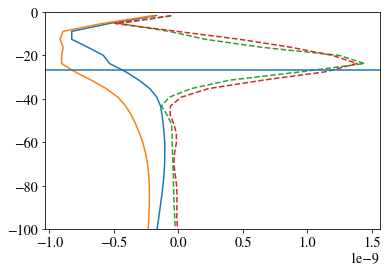

In [217]:
# plot SP

yl = slice(1000, 3000)
day = 6

plt.plot(GSP_WC.isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.plot(GSP_NC.isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.plot((SP_WC-GSP_WC).isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')), linestyle='--')
plt.plot((SP_NC-GSP_NC).isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')), linestyle='--')
plt.axhline(-dsWC_snap.hbl.isel(ocean_time=day, eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.ylim(-100,0)

In [136]:
uz

<xarray.DataArray (time: 7, s_rho: 100, eta_rho: 4002, xi_rho: 1002, ocean_time: 8)>
dask.array<sub, shape=(7, 100, 4002, 1002, 8), dtype=float32, chunksize=(1, 5, 4000, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float64 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * time     (time) float64 3.119e+07 3.128e+07 ... 3.162e+07 3.171e+07
    x_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
Dimensions without coordinates: ocean_time
Attributes:
    long_name:  averaged uw
    units:      meter2 second-2
    field:

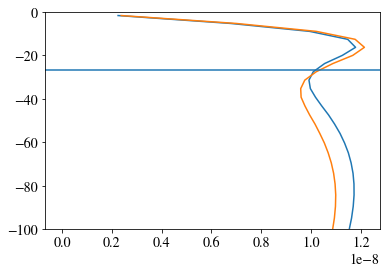

In [214]:
# plot VBF

yl = slice(1000, 3000)
day = 6

plt.plot(dsWC_eddy.wb.isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.plot(dsNC_eddy.wb.isel(eta_rho=yl, time=day).mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.ylim(-100,0)
plt.axhline(-dsWC_snap.hbl.isel(ocean_time=day, eta_rho=yl).mean(('eta_rho', 'xi_rho')))

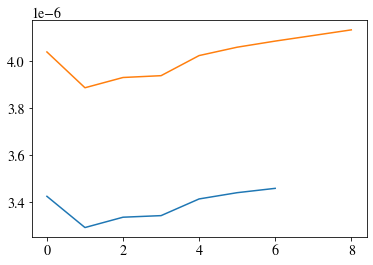

In [108]:
plt.plot(dsWC_eddy.usustr.mean(('eta_rho', 'xi_u')) + dsWC_eddy.vsvstr.mean(('eta_v', 'xi_rho')))
plt.plot(dsNC_eddy.usustr.mean(('eta_rho', 'xi_u')) + dsNC_eddy.vsvstr.mean(('eta_v', 'xi_rho')))

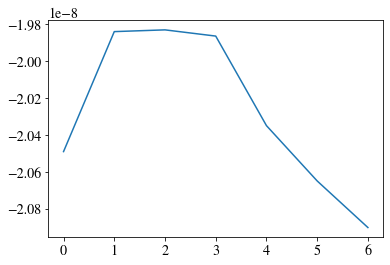

In [123]:
ww_WC = dsWC_eddy.usustr.mean(('eta_rho', 'xi_u')) + dsWC_eddy.vsvstr.mean(('eta_v', 'xi_rho'))
ww_NC = dsNC_eddy.usustr.mean(('eta_rho', 'xi_u')) + dsNC_eddy.vsvstr.mean(('eta_v', 'xi_rho'))
plt.plot((ww_WC - ww_NC)/30)


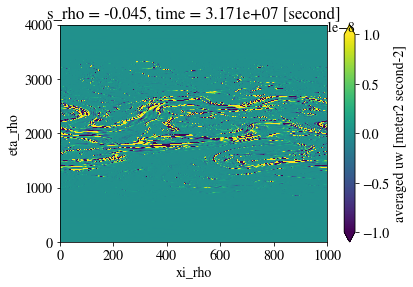

In [163]:
(GSP_WC - GSP_NC).isel(s_rho=-5, time=-1).plot(vmin=-1e-8, vmax=1e-8)

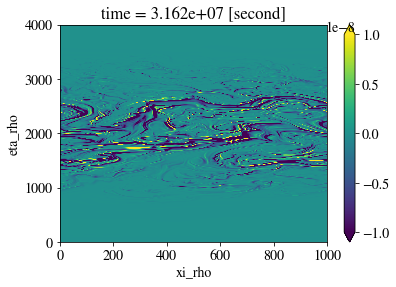

In [172]:
(dsWC_snap.EBF - dsWC_snap.EBFm).isel(ocean_time=6).plot(vmin=-1e-8, vmax=1e-8)

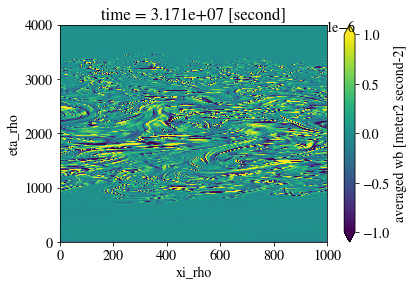

In [175]:
dsWC_eddy.wb.isel(time=6, s_rho=-5).plot(vmin=-1e-6, vmax=1e-6)

## LOOK AT PV FLUXES

In [197]:
runname = 'JET_NML_CFB_EKE'
dsWC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
dsWC_PV = dsWC_PV.swap_dims({'time':'ocean_time'})

runname = 'JET_NML_NOCFB_EKE'
dsNC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
dsNC_PV = dsNC_PV.swap_dims({'time':'ocean_time'})

dsNC_PV

<xarray.Dataset>
Dimensions:       (ocean_time: 9, auxil: 4, s_rho: 100, eta_rho: 4002, xi_rho: 1002, xi_u: 1001, eta_v: 4001)
Coordinates:
    time          (ocean_time) float64 3.119e+07 3.128e+07 ... 3.188e+07
Dimensions without coordinates: ocean_time, auxil, s_rho, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step     (ocean_time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    scrum_time    (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temp_rhs      (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    u_vmix_trans  (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 5, 4002, 1001), meta=np.ndarray>
    v_vmix_trans  (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 5, 4001, 1002), meta=np.ndarray>
    u_rhs         (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 5, 4002, 1001), meta=np.ndarray>
    v_rhs         (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 5, 4001, 1002), meta=np.ndarray>
Attributes: (12/55)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    skpp:          2005
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [198]:
JF_WC = dsWC_snap.bx[1:,:,:]*xroms.to_rho(dsWC_PV.v_rhs, gridWC) - dsWC_snap.by[1:,:,:]*xroms.to_rho(dsWC_PV.u_rhs, gridWC)
JF_WC

JF_NC = dsNC_snap.bx[1:,:,:]*xroms.to_rho(dsNC_PV.v_rhs, gridNC) - dsNC_snap.by[1:,:,:]*xroms.to_rho(dsNC_PV.u_rhs, gridWC)
JF_NC



<xarray.DataArray (ocean_time: 9, eta_rho: 4002, xi_rho: 1002, s_rho: 100)>
dask.array<sub, shape=(9, 4002, 1002, 100), dtype=float32, chunksize=(1, 4000, 1000, 5), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
    x_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    time     (ocean_time) float64 3.119e+07 3.128e+07 ... 3.18e+07 3.188e+07
Dimensions without coordinates: ocean_time, s_rho

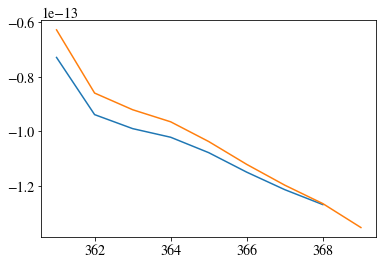

In [208]:
yl = slice(1000,3000)
plt.plot(JF_WC.time/86400, JF_WC.isel(s_rho=-1, eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.plot(JF_NC.time/86400, JF_NC.isel(s_rho=-1, eta_rho=yl).mean(('eta_rho', 'xi_rho')))

In [206]:
1e-13*86400


8.64e-09

In [211]:
dsWC_snap.hbl.isel(ocean_time=-1, eta_rho=yl).mean(('eta_rho', 'xi_rho')).values

array(27.28883, dtype=float32)